In [154]:
import csv
import string
import pprint
import codecs
import spacy
import nltk
import pywsd
import word2vec
from nltk.util import ngrams
from nltk import FreqDist
from nltk.tokenize import sent_tokenize,word_tokenize
from nltk.corpus import stopwords
from nltk.corpus import wordnet
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from pywsd.utils import lemmatize_sentence
import os
import sklearn
from sklearn import metrics
from sklearn.feature_extraction.text import CountVectorizer, HashingVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import SGDClassifier
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.naive_bayes import MultinomialNB
from sklearn.externals import joblib
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn import svm
import gensim
from gensim import corpora,models
import scipy
from scipy.sparse import csr_matrix
import re
import numpy as np
import pandas as pd
pd.set_option("display.max_colwidth", 200)
import pyLDAvis
import pyLDAvis.gensim
import seaborn as sns
%matplotlib inline
import matplotlib.pyplot as plt

In [115]:
#ouvrir les fichiers et traiter des informations, j'ai scrapyé 2319 commentaires Amazon de trois types de portables Samsung (S8,S9 256G,S9 64G, S10)
corpus = dict()
commentaires = []#Pour que chaque commentaire soit en liste
notes = []# Pour que chaque étoile soit en liste.
ligne = []
S7commentaires = []
S7notes = []
S8commentaires = []
S8notes = []
S9commentaires = []
S9notes = []
S10commentaires = []
S10notes = []
with open("reviewsS71.csv",'r',encoding="UTF-8")as f:#Samsung Galaxy S7 G930v 32GB Verizon Wireless CDMA 4G LTE Smartphone w
    while True:
        line = f.readline().strip().lower()
        if not line:
            break
        if ("out" in line):
            ligne.append(line)
            j = line.find(',"')
            commentaires.append(line[j+2:])
            notes.append(line[:j])
            S7commentaires.append(line[j+2:])
            S7notes.append(line[:j])            
            for key,value in corpus.items():
                corpus[line[j+2:]]=line[:j]
with open("reviewsS72.csv",'r',encoding="UTF-8")as f:#Samsung Galaxy S7 G930A 32GB Black Onyx - Unlocked GSM
    while True:
        line = f.readline().strip().lower()
        if not line:
            break
        if ("out" in line):
            ligne.append(line)
            j = line.find(',"')
            commentaires.append(line[j+2:])
            notes.append(line[:j])
            S7commentaires.append(line[j+2:])
            S7notes.append(line[:j])
            for key,value in corpus.items():
                corpus[line[j+2:]]=line[:j]
with open("reviews.csv",'r',encoding="UTF-8")as f:#Samsung Galaxy S8 Plus (S8+) (SM-G955FD) 4GB RAM / 64GB ROM 6.2-Inch
    while True:
        line = f.readline().strip().lower()
        if not line:
            break
        if ("out" in line):
            ligne.append(line)
            j = line.find(',"')
            commentaires.append(line[j+2:])
            notes.append(line[:j])
            S8commentaires.append(line[j+2:])
            S8notes.append(line[:j])
            for key,value in corpus.items():
                corpus[line[j+2:]]=line[:j]
with open("reviews1.csv",'r',encoding="UTF-8")as f:#Samsung-Galaxy S9-Unlocked-Version-256GB
    while True:
        line = f.readline().strip().lower()
        if not line:
            break
        if ("out" in line):
            ligne.append(line)
            j = line.find(',"')
            commentaires.append(line[j+2:])
            notes.append(line[:j])
            S9commentaires.append(line[j+2:])
            S9notes.append(line[:j])
            for key,value in corpus.items():
                corpus[line[j+2:]]=line[:j]
with open("reviews2.csv",'r',encoding="UTF-8")as f:#Samsung-Galaxy S9-Unlocked-Version-64GB
    while True:
        line = f.readline().strip().lower()
        if not line:
            break
        if ("out" in line):
            ligne.append(line)
            j = line.find(',"')
            commentaires.append(line[j+2:])
            notes.append(line[:j])
            S9commentaires.append(line[j+2:])
            S9notes.append(line[:j])
            for key,value in corpus.items():
                corpus[line[j+2:]]=line[:j]

with open("S10.csv",'r',encoding="UTF-8")as f:#Samsung-Galaxy 10
    while True:
        line = f.readline().strip().lower()
        if not line:
            break
        if ("out" in line):
            ligne.append(line)
            j = line.find(',"')
            commentaires.append(line[j+2:])
            notes.append(line[:j])
            S10commentaires.append(line[j+2:])
            S10notes.append(line[:j])

#stopword
with open("Commentaires.txt",'w',encoding="UTF-8")as f:
    for x in commentaires:
        f.write(x)
        f.write('\n')
stopWords = set(stopwords.words('english'))
need = ["not","hadn't","don't","hasn't","no","mustn't","doesn't","isn","weren't","isn't","won't","wouldn't","couldn't","didn't","shouldn't","aren't","mightn't","wasn't", "needn't"]
for i in need:
    if i in stopWords:
        stopWords.remove(i)
new = ["umm","mcg","dr.","#","@","uhh","plus","S8","S9","phone","the","you","(",")"]
for i in new:
    stopWords.add(i)

#remove stop words
def remove_stopwords(rev):
    rev = rev.split(" ")
    rev_new = " ".join([i for i in rev if i not in stopWords])
    return rev_new
a = []
for i in range(len(commentaires)):
    a.append(remove_stopwords(commentaires[i]))
commentaires = a

a = []
for i in range(len(S7commentaires)):
    a.append(remove_stopwords(S7commentaires[i]))
S7commentaires = a

a = []
for i in range(len(S8commentaires)):
    a.append(remove_stopwords(S8commentaires[i]))
S8commentaires = a

a = []
for i in range(len(S9commentaires)):
    a.append(remove_stopwords(S9commentaires[i]))
S9commentaires = a

a = []
for i in range(len(S10commentaires)):
    a.append(remove_stopwords(S10commentaires[i]))
S10commentaires = a

#remove the numbers
def remove_numbers(rev):
    rev = re.sub("\d+","",rev)
    return rev
for i in range(len(commentaires)):
    commentaires[i]=remove_numbers(commentaires[i])

for i in range(len(S7commentaires)):
    S7commentaires[i]=remove_numbers(S7commentaires[i])

for i in range(len(S8commentaires)):
    S8commentaires[i]=remove_numbers(S8commentaires[i])
    
for i in range(len(S9commentaires)):
    S9commentaires[i]=remove_numbers(S9commentaires[i])

for i in range(len(S10commentaires)):
    S10commentaires[i]=remove_numbers(S10commentaires[i])

#remove short words (length < 3)
def remove_short_words(rev):
    rev = rev.split(" ")
    for word in rev:
        if len(word)<=2:
            rev.remove(word)
    return " ".join(rev)

tmp = []
for i in range(len(commentaires)):
    tmp.append(remove_short_words(commentaires[i]))
commentaires = tmp

tmp = []
for i in range(len(S7commentaires)):
    tmp.append(remove_short_words(S7commentaires[i]))
S7commentaires = tmp

tmp = []
for i in range(len(S8commentaires)):
    tmp.append(remove_short_words(S8commentaires[i]))
S8commentaires = tmp

tmp = []
for i in range(len(S9commentaires)):
    tmp.append(remove_short_words(S9commentaires[i]))
S9commentaires = tmp

tmp = []
for i in range(len(S10commentaires)):
    tmp.append(remove_short_words(S10commentaires[i]))
S10commentaires = tmp

#remove punctuations
def remove_punctuations(list_commentaires):
    punctuation = set(string.punctuation)
    for i in range(len(list_commentaires)):
        b = list_commentaires[i]
        for s in b:
            if(s in punctuation and s!="'"):
                list_commentaires[i]=list_commentaires[i].replace(s,"")
    return list_commentaires

remove_punctuations(commentaires)
remove_punctuations(S7commentaires)
remove_punctuations(S8commentaires)
remove_punctuations(S9commentaires)
remove_punctuations(S10commentaires)
print("done")

<>:144: DeprecationWarning: invalid escape sequence \d
<>:144: DeprecationWarning: invalid escape sequence \d
<>:144: DeprecationWarning: invalid escape sequence \d
<ipython-input-115-f80ab1674f2e>:144: DeprecationWarning: invalid escape sequence \d
  rev = re.sub("\d+","",rev)


done


In [116]:
print(len(S7commentaires))
print(len(S8commentaires))
print(len(S9commentaires))
print(len(S10commentaires))

1757
1200
2400
119


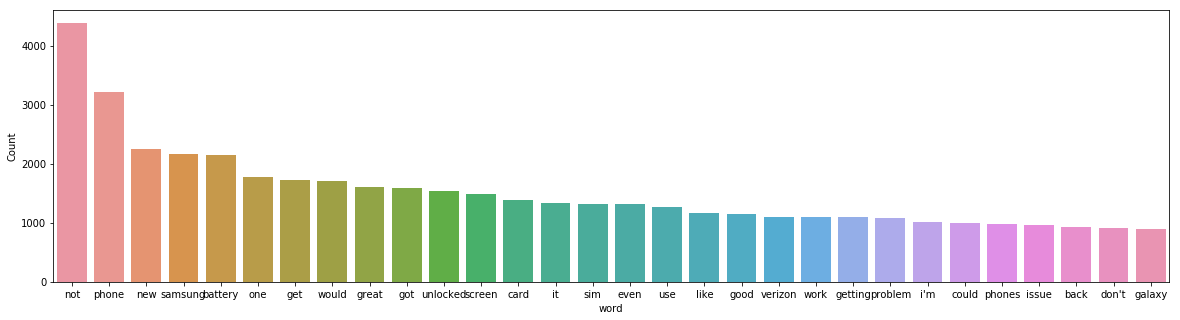

In [117]:
def frequence_mots(x, terms = 30):
    all_words = ' '.join([text for text in x])
    all_words = all_words.split()

    fdist = FreqDist(all_words)
    words_df = pd.DataFrame({'word':list(fdist.keys()), 'count':list(fdist.values())})

    # selecting top 20 most frequent words
    d = words_df.nlargest(columns="count", n = terms) 
    plt.figure(figsize=(20,5))
    ax = sns.barplot(data=d, x= "word", y = "count")
    ax.set(ylabel = 'Count')
    plt.show()
frequence_mots(commentaires)

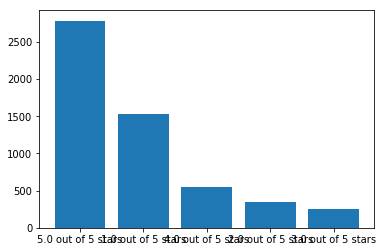

In [118]:
#Collecter tous les commentaires traités 
with open("reviewsTotal.csv","w",encoding = "UTF-8")as csvfile:
    fieldnames = ["notes","commentaires"]
    writer = csv.DictWriter(csvfile,fieldnames=fieldnames)
    writer.writeheader()
    for i in range(len(commentaires)):
        writer.writerow({'notes':notes[i],'commentaires':commentaires[i]})

#visualiser la distribution de notes en étoiles
dataset = pd.read_csv("reviewsTotal.csv")
summarised_results = dataset["notes"].value_counts()
plt.bar(summarised_results.keys(), summarised_results.values)
plt.show()

In [119]:
#prétraitement
tokenisation = []
lemme = []
POS_Tagger = []
lemmatizer = WordNetLemmatizer()
for i in range(len(commentaires)):
    commentaires[i] = commentaires[i].replace('\n','')
    tokenisation.append(word_tokenize(commentaires[i]))
    POS_Tagger.append(nltk.pos_tag(word_tokenize(commentaires[i])))

In [120]:
S7tokenisation = []
S7POS_Tagger = []
for i in range(len(S7commentaires)):
    S7commentaires[i] = S7commentaires[i].replace('\n','')
    S7tokenisation.append(word_tokenize(S7commentaires[i]))
    S7POS_Tagger.append(nltk.pos_tag(word_tokenize(S7commentaires[i])))

S8tokenisation = []
S8POS_Tagger = []
for i in range(len(S8commentaires)):
    S8commentaires[i] = S8commentaires[i].replace('\n','')
    S8tokenisation.append(word_tokenize(S8commentaires[i]))
    S8POS_Tagger.append(nltk.pos_tag(word_tokenize(S8commentaires[i])))

In [121]:
S9tokenisation = []
S9POS_Tagger = []
for i in range(len(S9commentaires)):
    S9commentaires[i] = S9commentaires[i].replace('\n','')
    S9tokenisation.append(word_tokenize(S9commentaires[i]))
    S9POS_Tagger.append(nltk.pos_tag(word_tokenize(S9commentaires[i])))

In [122]:
S10tokenisation = []
S10POS_Tagger = []
for i in range(len(S10commentaires)):
    S10commentaires[i] = S9commentaires[i].replace('\n','')
    S10tokenisation.append(word_tokenize(S9commentaires[i]))
    S10POS_Tagger.append(nltk.pos_tag(word_tokenize(S9commentaires[i])))

In [131]:
#Lemmatisation
lemme = []
def get_wordnet_pos(word):
    """Map POS tag to first character lemmatize() accepts"""
    tag = nltk.pos_tag([word])[0][1][0].upper()
    L1 = ['J','N','V','R']
    if tag in L1:
        tag_dict = {"J": wordnet.ADJ,
                    "N": wordnet.NOUN,
                    "V": wordnet.VERB,
                    "R": wordnet.ADV,
                    }
        return tag_dict[nltk.pos_tag([word])[0][1][0].upper()]
    else:
        return wordnet.NOUN

for tokens in tokenisation:
    L = []
    for word in tokens:
        L.append(lemmatizer.lemmatize(word,pos = get_wordnet_pos(word)))
    lemme.append(" ".join(L))

In [132]:
S7lemme = []
for tokens in S7tokenisation:
    L = []
    for word in tokens:
        L.append(lemmatizer.lemmatize(word,pos = get_wordnet_pos(word)))
    S7lemme.append(" ".join(L))

In [130]:
S8lemme = []
for tokens in S8tokenisation:
    L = []
    for word in tokens:
        L.append(lemmatizer.lemmatize(word,pos = get_wordnet_pos(word)))
    S8lemme.append(" ".join(L))

In [133]:
S9lemme = []
for tokens in S9tokenisation:
    L = []
    for word in tokens:
        L.append(lemmatizer.lemmatize(word,pos = get_wordnet_pos(word)))
    S9lemme.append(" ".join(L))

In [129]:
S10lemme = []
for tokens in S10tokenisation:
    L = []
    for word in tokens:
        L.append(lemmatizer.lemmatize(word,pos = get_wordnet_pos(word)))
    S10lemme.append(" ".join(L))

In [15]:
#résultat en page HTML:
def Edition_en_HTML(liste):
    w = codecs.open("prétraitement.html", "w","utf-8")
    w.write("<table border= '1'>")
    for ligne in liste:
        w.write("<tr><td>")
        w.write("</td><td>".join([str(x) for x in ligne]))
        w.write("</td><tr>")
    w.write("</table>")
    w.close()

L = [[[]for i in range(5)]for j in range(len(commentaires))]
L[0] = ['Commentaires','Tokenisation','POS Tagger','lemme','Notes']
for i in range(1,len(commentaires)):
    L[i][0] = commentaires[i-1]
    L[i][1] = tokenisation[i-1]
    L[i][2] = POS_Tagger[i-1]
    L[i][3] = lemme[i-1]
    L[i][4] = notes[i-1]
Edition_en_HTML(L)

In [16]:
#Récupération et assemblage des Tokens et leur POS-Tagger, et leur Lemme pour chaque commentaire:
with open("Corpus.txt",'w',encoding = "UTF-8") as f:
    for i in range(len(commentaires)):
        f.write("Commentaire{}".format(i+1))
        f.write(" : ")
        f.write(str(list(zip(POS_Tagger[i],lemme[i]))))
        f.write("\n")

In [17]:
with open("Total.csv","w",encoding = "UTF-8")as csvfile:
    fieldnames = ["commentaires","notes"]
    writer = csv.DictWriter(csvfile,fieldnames=fieldnames)
    writer.writeheader()
    for i in range(len(commentaires)):
        writer.writerow({'commentaires':commentaires[i],'notes':notes[i]})

In [18]:
df = pd.read_csv("Total.csv")
df.head()

,commentaires,notes
0,far good hard tell refurbished not new received last thursday busy installing updates apps accounts order switch existing windows phone not activated verizon network verified swapping old phone's ...,5.0 out of 5 stars
1,believe going best yet came time promised looks brand new setting transferring data breeze love always on screen shows time date well certain information really handsome right size methe reason no...,4.0 out of 5 stars
2,product works phone headphone jack not don't time return actively need cell business i'd appreciate changing wording refurbished used broken consumers clear what's up like new pretty clear apply t...,2.0 out of 5 stars
3,really nice price everything perfect except try play music aux cord car loud annoying static sound won't away bypass though bluetooth adapter though not huge issue issue i've thus far everything e...,4.0 out of 5 stars
4,battery life terrible last hours operating system slow christmas apps quit faster battery does probably return not worth hassle not mention risking feels like first degree burns thing overheating ...,3.0 out of 5 stars


In [44]:
with open("S7.csv","w",encoding = "UTF-8")as csvfile:
    fieldnames = ["commentaires","notes"]
    writer = csv.DictWriter(csvfile,fieldnames=fieldnames)
    writer.writeheader()
    for i in range(len(S7commentaires)):
        writer.writerow({'commentaires':S7commentaires[i],'notes':S7notes[i]})

with open("S8.csv","w",encoding = "UTF-8")as csvfile:
    fieldnames = ["commentaires","notes"]
    writer = csv.DictWriter(csvfile,fieldnames=fieldnames)
    writer.writeheader()
    for i in range(len(S8commentaires)):
        writer.writerow({'commentaires':S8commentaires[i],'notes':S8notes[i]})

with open("S9.csv","w",encoding = "UTF-8")as csvfile:
    fieldnames = ["commentaires","notes"]
    writer = csv.DictWriter(csvfile,fieldnames=fieldnames)
    writer.writeheader()
    for i in range(len(S9commentaires)):
        writer.writerow({'commentaires':S9commentaires[i],'notes':S9notes[i]})

In [134]:
print(len(commentaires))
print(len(notes))
print(len(lemme))#
print(len(POS_Tagger))
print(len(tokenisation))
print(len(S10commentaires))
print(len(S10lemme))
print(len(S10notes))
print(len(S10POS_Tagger))
print(len(S10tokenisation))
print(len(S9commentaires))
print(len(S9lemme))
print(len(S9notes))#
print(len(S9POS_Tagger))
print(len(S9tokenisation))
print(len(S8commentaires))
print(len(S8lemme))
print(len(S8notes))
print(len(S8POS_Tagger))
print(len(S8tokenisation))
print(len(S7commentaires))
print(len(S7lemme))
print(len(S7notes))
print(len(S7POS_Tagger))
print(len(S7tokenisation))

5476
5476
5476
5476
5476
119
119
119
119
119
2400
2400
2400
2400
2400
1200
1200
1200
1200
1200
1757
1757
1757
1757
1757


### Training Model Naïve Bayes

In [137]:
notes[:5]

['5.0 out of 5 stars',
 '4.0 out of 5 stars',
 '2.0 out of 5 stars',
 '4.0 out of 5 stars',
 '3.0 out of 5 stars']

In [136]:
# Pour que la note soit en 0 (négatif) et 1(positif)
n = []
for i in range(len(notes)):
    if notes[i]=="5.0 out of 5 stars":
        n.append('p')
    elif notes[i]=="4.0 out of 5 stars":
        n.append('p')
    elif notes[i]=="3.0 out of 5 stars":
        n.append('n')
    elif notes[i]=="2.0 out of 5 stars": 
        n.append('n')
    elif notes[i]=="1.0 out of 5 stars":
        n.append('n')

In [138]:
n[:5]

['p', 'p', 'n', 'p', 'n']

In [173]:
#avec commentaires
cv = CountVectorizer(max_features = 5000)
tf = TfidfVectorizer(min_df = 1,stop_words = "english")
x_train = cv.fit_transform(commentaires[:2738])
x_test = cv.transform(commentaires[2738:])
transformer = TfidfTransformer()
tfidf_x_train = transformer.fit_transform(x_train)
tfidf_x_test = transformer.transform(x_test)
y_train = n[:2738]
y_test = n[2738:]
#En utilisant CountVectorizer pour les commentaires
np.seterr(divide='ignore', invalid='ignore')
mnbforCV = MultinomialNB(alpha=0.01)
mnbforCV.fit(x_train,y_train)
mnb_y_pred=mnbforCV.predict(x_test)
mnbforCV_score = accuracy_score(y_test, mnb_y_pred)
print("Accuracy in CountVectorizer for naïve bayes:   {:.3f}".format(mnbforCV_score))
print("Training set score: {:.3f}".format(mnbforCV.score(x_train, y_train)))
print("Test set score: {:.3f}".format(mnbforCV.score(x_test, y_test)))
mnb_cfm = confusion_matrix(y_test, mnb_y_pred)
print("Confusion matrix:")
print(mnb_cfm, end='\n\n')
print('-'*15)
print(np.array([['VN', 'FP'],[ 'FN' , 'VP']]))
# En utilisant TFidf pour les commentaires
mnbfortif = MultinomialNB(alpha=0.01)
mnbfortif.fit(tfidf_x_train,y_train)
mnb_y_pred=mnbforCV.predict(tfidf_x_test)
mnbfortif_score = accuracy_score(y_test,mnb_y_pred)
print("Accuracy in TFIDFVectorizer for naïve bayes: {:.3f}".format(mnbfortif_score))
print("Training set score: {:.3f}".format(mnbfortif.score(x_train, y_train)))
print("Test set score: {:.3f}".format(mnbfortif.score(x_test, y_test)))
mnb_cfm = confusion_matrix(y_test, mnb_y_pred)
print("Confusion matrix:")
print(mnb_cfm, end='\n\n')
print('-'*15)
print(np.array([['VN', 'FP'],[ 'FN' , 'VP']]))

Accuracy in CountVectorizer for naïve bayes:   0.778
Training set score: 0.963
Test set score: 0.778
Confusion matrix:
[[ 376  452]
 [ 157 1753]]

---------------
[['VN' 'FP']
 ['FN' 'VP']]
Accuracy in TFIDFVectorizer for naïve bayes: 0.772
Training set score: 0.977
Test set score: 0.808
Confusion matrix:
[[ 344  484]
 [ 141 1769]]

---------------
[['VN' 'FP']
 ['FN' 'VP']]


In [174]:
#avec lemmes
cv = CountVectorizer(max_features = 5000)
tf = TfidfVectorizer(min_df = 1,stop_words = "english")
x_train = cv.fit_transform(lemme[:2738])
x_test = cv.transform(lemme[2738:])
transformer = TfidfTransformer()
tfidf_x_train = transformer.fit_transform(x_train)
tfidf_x_test = transformer.transform(x_test)
y_train = n[:2738]
y_test = n[2738:]
#En utilisant CountVectorizer pour les lemmes de tous les commentaires
np.seterr(divide='ignore', invalid='ignore')
mnbforCVlemme = MultinomialNB(alpha=0.01).fit(x_train,y_train)
mnb_y_pred=mnbforCVlemme.predict(x_test)
mnbforCVlemme_score = accuracy_score(y_test, mnb_y_pred)
print("Accuracy in CountVectorizer for naïve bayes:   {:.3f}".format(mnbforCVlemme_score))
print("Training set score: {:.3f}".format(mnbforCVlemme.score(x_train, y_train)))
print("Test set score: {:.3f}".format(mnbforCVlemme.score(x_test, y_test)))
mnb_cfm = confusion_matrix(y_test, mnb_y_pred)
print("Confusion matrix:")
print(mnb_cfm, end='\n\n')
print('-'*15)
print(np.array([['VN', 'FP'],[ 'FN' , 'VP']]))
# En utilisant TFidf pour les lemmes de tous les commentaires
mnbfortif = MultinomialNB(alpha=0.01)
mnbfortif.fit(tfidf_x_train,y_train)
mnb_y_pred=mnbfortif.predict(tfidf_x_test)
mnbfortif_score = accuracy_score(y_test,mnb_y_pred)
print("Accuracy in TFIDFVectorizer for naïve bayes: {:.3f}".format(mnbfortif_score))
print("Training set score: {:.3f}".format(mnbfortif.score(x_train, y_train)))
print("Test set score: {:.3f}".format(mnbfortif.score(x_test, y_test)))
mnb_cfm = confusion_matrix(y_test, mnb_y_pred)
print("Confusion matrix:")
print(mnb_cfm, end='\n\n')
print('-'*15)
print(np.array([['VN', 'FP'],[ 'FN' , 'VP']]))

Accuracy in CountVectorizer for naïve bayes:   0.763
Training set score: 0.958
Test set score: 0.763
Confusion matrix:
[[ 344  484]
 [ 164 1746]]

---------------
[['VN' 'FP']
 ['FN' 'VP']]
Accuracy in TFIDFVectorizer for naïve bayes: 0.778
Training set score: 0.970
Test set score: 0.800
Confusion matrix:
[[ 312  516]
 [  92 1818]]

---------------
[['VN' 'FP']
 ['FN' 'VP']]


In [162]:
#En utilisant CountVectorizer pour les lemmes de tous les commentaires
np.seterr(divide='ignore', invalid='ignore')
mnbforCVlemme = MultinomialNB(alpha=0.01).fit(x_train,y_train)
mnb_y_pred=mnbforCVlemme.predict(x_test)
mnbforCVlemme_score = accuracy_score(y_test, mnb_y_pred)
print("Accuracy in CountVectorizer for naïve bayes:   {:.3f}".format(mnbforCVlemme_score))
print("Training set score: {:.3f}".format(mnbforCVlemme.score(x_train, y_train)))
print("Test set score: {:.3f}".format(mnbforCVlemme.score(x_test, y_test)))
mnb_cfm = confusion_matrix(y_test, mnb_y_pred)
print("Confusion matrix:")
print(mnb_cfm, end='\n\n')
print('-'*15)
print(np.array([['VN', 'FP'],[ 'FN' , 'VP']]))

Accuracy in CountVectorizer for naïve bayes:   0.763
Training set score: 0.958
Test set score: 0.763
Confusion matrix:
[[ 344  484]
 [ 164 1746]]

---------------
[['VN' 'FP']
 ['FN' 'VP']]


In [163]:
# En utilisant TFidf pour les lemmes de tous les commentaires
mnbfortif = MultinomialNB(alpha=0.01)
mnbfortif.fit(tfidf_x_train,y_train)
mnb_y_pred=mnbforCV.predict(tfidf_x_test)
mnbfortif_score = accuracy_score(y_test,mnb_y_pred)
print("Accuracy in TFIDFVectorizer for naïve bayes: {:.3f}".format(mnbfortif_score))
print("Training set score: {:.3f}".format(mnbfortif.score(x_train, y_train)))
print("Test set score: {:.3f}".format(mnbfortif.score(x_test, y_test)))
mnb_cfm = confusion_matrix(y_test, mnb_y_pred)
print("Confusion matrix:")
print(mnb_cfm, end='\n\n')
print('-'*15)
print(np.array([['VN', 'FP'],[ 'FN' , 'VP']]))

Accuracy in TFIDFVectorizer for naïve bayes: 0.764
Training set score: 0.970
Test set score: 0.800
Confusion matrix:
[[ 332  496]
 [ 151 1759]]

---------------
[['VN' 'FP']
 ['FN' 'VP']]


In [175]:
#En ajoutant N(3)-Gram
#avec commentaires
cv1 = CountVectorizer(ngram_range=(3,3),max_features = 5000)
tf = TfidfVectorizer(min_df = 1,stop_words = "english")
x_train = cv1.fit_transform(lemme[:2738])
x_test = cv1.transform(lemme[2738:])
transformer = TfidfTransformer()
tfidf_x_train = transformer.fit_transform(x_train)
tfidf_x_test = transformer.transform(x_test)
y_train = n[:2738]
y_test = n[2738:]
#En utilisant CountVectorizer pour les commentaires
np.seterr(divide='ignore', invalid='ignore')
mnbforCV = MultinomialNB(alpha=0.01)
mnbforCV.fit(x_train,y_train)
mnb_y_pred=mnbforCV.predict(x_test)
mnbforCV_score = accuracy_score(y_test, mnb_y_pred)
print("Accuracy in CountVectorizer for naïve bayes in Tri-Gram:   {:.3f}".format(mnbforCV_score))
print("Training set score: {:.3f}".format(mnbforCV.score(x_train, y_train)))
print("Test set score: {:.3f}".format(mnbforCV.score(x_test, y_test)))
mnb_cfm = confusion_matrix(y_test, mnb_y_pred)
print("Confusion matrix:")
print(mnb_cfm, end='\n\n')
print('-'*15)
print(np.array([['VN', 'FP'],[ 'FN' , 'VP']]))
# En utilisant TFidf pour les commentaires
mnbfortif = MultinomialNB(alpha=0.01)
mnbfortif.fit(tfidf_x_train,y_train)
mnb_y_pred=mnbforCV.predict(tfidf_x_test)
mnbfortif_score = accuracy_score(y_test,mnb_y_pred)
print("Accuracy in TFIDFVectorizer for naïve bayes in Tri-Gram: {:.3f}".format(mnbfortif_score))
print("Training set score: {:.3f}".format(mnbfortif.score(x_train, y_train)))
print("Test set score: {:.3f}".format(mnbfortif.score(x_test, y_test)))
mnb_cfm = confusion_matrix(y_test, mnb_y_pred)
print("Confusion matrix:")
print(mnb_cfm, end='\n\n')
print('-'*15)
print(np.array([['VN', 'FP'],[ 'FN' , 'VP']]))

Accuracy in CountVectorizer for naïve bayes in Tri-Gram:   0.726
Training set score: 0.946
Test set score: 0.726
Confusion matrix:
[[ 122  706]
 [  44 1866]]

---------------
[['VN' 'FP']
 ['FN' 'VP']]
Accuracy in TFIDFVectorizer for naïve bayes in Tri-Gram: 0.726
Training set score: 0.951
Test set score: 0.727
Confusion matrix:
[[ 122  706]
 [  45 1865]]

---------------
[['VN' 'FP']
 ['FN' 'VP']]


### Créer un modèle LDA pour voir les hot topics dans les commentaires, surtout pour négatifs.

In [178]:
#Classifier tous les commentaires et trouver les commenatires négatifs respectivement des S7,S8,S9,S10
l = list(zip(commentaires,n))
positif = []
negatif = []
for i in range(len(l)):
    if l[i][1]=='n':
        negatif.append(l[i][0])
    elif (l[i][1][0]=='p'):
        positif.append(l[i][0])
    else:
        pass
print(len(negatif))
print(len(positif))

2139
3337


In [200]:
l = list(zip(S7commentaires,S7notes))
S7positif = []
S7negatif = []
for i in range(len(l)):
    if (l[i][1][0]=='1') or (l[i][1][0]=='2'):
        S7negatif.append(l[i][0])
    elif (l[i][1][0]=='4') or (l[i][1][0]=='5'):
        S7positif.append(l[i][0])
    else:
        pass

l = list(zip(S8commentaires,S8notes))
S8positif = []
S8negatif = []
for i in range(len(l)):
    if (l[i][1][0]=='1') or (l[i][1][0]=='2'):
        S8negatif.append(l[i][0])
    elif (l[i][1][0]=='4') or (l[i][1][0]=='5'):
        S8positif.append(l[i][0])
    else:
        pass
l = list(zip(S9commentaires,S9notes))
S9positif = []
S9negatif = []
for i in range(len(l)):
    if (l[i][1][0]=='1') or (l[i][1][0]=='2'):
        S9negatif.append(l[i][0])
    elif (l[i][1][0]=='4') or (l[i][1][0]=='5'):
        S9positif.append(l[i][0])
    else:
        pass
l = list(zip(S10commentaires,S10notes))
S10positif = []
S10negatif = []
for i in range(len(l)):
    if (l[i][1][0]=='1') or (l[i][1][0]=='2'):
        S10negatif.append(l[i][0])
    elif (l[i][1][0]=='4') or (l[i][1][0]=='5'):
        S10positif.append(l[i][0])
    else:
        pass
print(len(S7negatif))
print(len(S7positif))
print(len(S8negatif))
print(len(S8positif))
print(len(S9negatif))
print(len(S9positif))
print(len(S10negatif))
print(len(S10positif))

985
722
319
811
546
1726
31
78


In [180]:
# Créer un modèle LDA pour voir les hot topics dans les commentaires sans classification.
nlp = spacy.load('en_core_web_lg',disable=["parser","ner"])
def lemmatization(texts, tags=['NOUN', 'ADJ']): # filter noun and adjective
    output = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        output.append([token.lemma_ for token in doc if token.pos_ in tags])
    return output

In [181]:
# Tous les Commentaires
reviews = lemme
tokenized_reviews = pd.Series(reviews).apply(lambda x: x.split())
reviews_lemme = lemmatization(tokenized_reviews)
dictionary = corpora.Dictionary(reviews_lemme)
Matrice = [dictionary.doc2bow(word) for word in reviews_lemme] 

In [182]:
LDA = gensim.models.ldamodel.LdaModel
lda_model = LDA(corpus=Matrice,id2word=dictionary,num_topics=10, random_state=123,chunksize=1000,passes=50)

In [183]:
lda_model.print_topics()

[(0,
  '0.106*"card" + 0.095*"sim" + 0.059*"memory" + 0.039*"chip" + 0.031*"phone" + 0.030*"setup" + 0.027*"initial" + 0.025*"ultra" + 0.024*"tip" + 0.023*"verizon"'),
 (1,
  '0.034*"phone" + 0.026*"samsung" + 0.026*"new" + 0.018*"work" + 0.016*"great" + 0.015*"verizon" + 0.015*"amazon" + 0.013*"time" + 0.012*"product" + 0.012*"call"'),
 (2,
  '0.052*"phone" + 0.051*"battery" + 0.037*"issue" + 0.034*"samsung" + 0.023*"problem" + 0.022*"order" + 0.017*"amazon" + 0.012*"charge" + 0.012*"sure" + 0.012*"business"'),
 (3,
  '0.047*"cell" + 0.033*"master" + 0.031*"phone" + 0.028*"minute" + 0.025*"reset" + 0.025*"electronic" + 0.023*"everything" + 0.022*"kiss" + 0.019*"service" + 0.019*"email"'),
 (4,
  '0.041*"wireless" + 0.037*"full" + 0.033*"return" + 0.031*"case" + 0.029*"att" + 0.026*"black" + 0.025*"screen" + 0.024*"nothing" + 0.021*"bloatware" + 0.019*"help"'),
 (5,
  '0.053*"edge" + 0.030*"plan" + 0.025*"signal" + 0.022*"international" + 0.020*"area" + 0.018*"make" + 0.017*"case" + 0.

In [184]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, Matrice, dictionary)
vis

C:\Users\WANGZijian\Anaconda3\lib\site-packages\pyLDAvis\_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
6     -0.109854  0.153446       1        1  20.900051
1     -0.131092  0.056935       2        1  18.974279
2     -0.225919  0.045532       3        1  17.119335
7     -0.141708  0.113189       4        1  13.222988
9     -0.112242 -0.048325       5        1   8.420395
3     -0.026706 -0.193706       6        1   6.819808
0      0.022358 -0.313451       7        1   6.337780
8      0.213294  0.048495       8        1   3.329931
4      0.270891  0.116551       9        1   3.298785
5      0.240979  0.021335      10        1   1.576639, topic_info=     Category         Freq         Term        Total  loglift  logprob
term                                                                  
6     Default  1380.000000         card  1380.000000  30.0000  30.0000
219   Default   790.000000       device   790.000000  29.0000  29.0000
23    Default  1292.000000          sim  1292.000000  28.0000  28.0000
44    Default  1396.000000       screen  1396.000000  27.0000  27.0000
17    Default  2113.000000          new  2113.000000  26.0000  26.0000
32    Default  1685.000000         work  1685.000000  25.0000  25.0000
87    Default  2041.000000      battery  2041.000000  24.0000  24.0000
276   Default   515.000000       memory   515.000000  23.0000  23.0000
55    Default   443.000000         cell   443.000000  22.0000  22.0000
77    Default  1210.000000        issue  1210.000000  21.0000  21.0000
20    Default  3952.000000        phone  3952.000000  20.0000  20.0000
292   Default   450.000000          box   450.000000  19.0000  19.0000
691   Default   422.000000       return   422.000000  18.0000  18.0000
30    Default   987.000000      verizon   987.000000  17.0000  17.0000
330   Default   481.000000         case   481.000000  16.0000  16.0000
151   Default   407.000000      charger   407.000000  15.0000  15.0000
136   Default   592.000000       seller   592.000000  14.0000  14.0000
941   Default   342.000000         chip   342.000000  13.0000  13.0000
1170  Default   268.000000     unlocked   268.000000  12.0000  12.0000
263   Default   452.000000       couple   452.000000  11.0000  11.0000
157   Default  1133.000000      problem  1133.000000  10.0000  10.0000
821   Default   391.000000          att   391.000000   9.0000   9.0000
732   Default   357.000000        money   357.000000   8.0000   8.0000
121   Default   799.000000       camera   799.000000   7.0000   7.0000
900   Default   266.000000         edge   266.000000   6.0000   6.0000
1546  Default   311.000000       master   311.000000   5.0000   5.0000
1377  Default   300.000000          gsm   300.000000   4.0000   4.0000
19    Default   651.000000        order   651.000000   3.0000   3.0000
72    Default   623.000000   everything   623.000000   2.0000   2.0000
0     Default   506.000000         able   506.000000   1.0000   1.0000
...       ...          ...          ...          ...      ...      ...
879   Topic10    19.492437    recommend    20.468983   4.1010  -4.7046
152   Topic10    18.958185   functional    19.934669   4.0997  -4.7324
1011  Topic10    14.893497          gps    15.870070   4.0864  -4.9737
583   Topic10    13.860970     moisture    14.837453   4.0818  -5.0455
1329  Topic10    13.566868      visible    14.543507   4.0804  -5.0670
1449  Topic10    12.543961         foot    13.520477   4.0749  -5.1454
1402  Topic10    12.434633         book    13.411249   4.0743  -5.1541
1129  Topic10    11.647030  touchscreen    12.623554   4.0694  -5.2196
1315  Topic10    11.411695          act    12.388508   4.0677  -5.2400
1199  Topic10    11.228268     calendar    12.204789   4.0665  -5.2562
1448  Topic10    11.113026     drawback    12.089609   4.0656  -5.2665
1254  Topic10    10.297438         site    11.273952   4.0593  -5.3427
1230  Topic10     9.467624       tablet    10.444180   4.0517  -5.4267
4530  Topic10     9.340683          off    

In [185]:
reviews = negatif
tokenized_reviews = pd.Series(reviews).apply(lambda x: x.split())
reviews_lemme = lemmatization(tokenized_reviews)
dictionary = corpora.Dictionary(reviews_lemme)
Matrice = [dictionary.doc2bow(word) for word in reviews_lemme] 

In [186]:
LDA = gensim.models.ldamodel.LdaModel
lda_model = LDA(corpus=Matrice,id2word=dictionary,num_topics=10, random_state=123,chunksize=1000,passes=50)

In [187]:
lda_model.print_topics()

[(0,
  '0.099*"screen" + 0.045*"month" + 0.035*"charge" + 0.034*"battery" + 0.031*"option" + 0.030*"anything" + 0.030*"less" + 0.027*"fast" + 0.024*"carrier" + 0.023*"glass"'),
 (1,
  '0.072*"new" + 0.056*"phone" + 0.040*"able" + 0.039*"screen" + 0.037*"everything" + 0.036*"light" + 0.035*"sim" + 0.030*"card" + 0.026*"stuck" + 0.024*"mode"'),
 (2,
  '0.081*"issue" + 0.071*"samsung" + 0.048*"battery" + 0.034*"phone" + 0.031*"seller" + 0.027*"safemode" + 0.022*"galaxy" + 0.021*"sure" + 0.019*"piece" + 0.019*"android"'),
 (3,
  '0.049*"iphone" + 0.048*"good" + 0.047*"edge" + 0.038*"screen" + 0.022*"camera" + 0.022*"pixel" + 0.021*"use" + 0.018*"case" + 0.018*"samsung" + 0.018*"display"'),
 (4,
  '0.026*"phone" + 0.025*"version" + 0.024*"amazon" + 0.024*"time" + 0.020*"fingerprint" + 0.019*"quality" + 0.019*"warranty" + 0.017*"display" + 0.017*"new" + 0.015*"video"'),
 (5,
  '0.044*"verizon" + 0.024*"notification" + 0.024*"phone" + 0.020*"work" + 0.018*"network" + 0.017*"big" + 0.016*"diff

In [188]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, Matrice, dictionary)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
7      0.223891  0.002090       1        1  24.612123
2     -0.026587 -0.146668       2        1  13.393209
1      0.146718  0.275883       3        1  12.542780
6     -0.092912 -0.140942       4        1  11.523657
4      0.119511 -0.073935       5        1   7.233731
5     -0.110760  0.000014       6        1   7.054742
0      0.116562  0.136272       7        1   6.624412
8     -0.345273  0.199655       8        1   6.488861
9     -0.016035 -0.146447       9        1   6.310010
3     -0.015115 -0.105923      10        1   4.216476, topic_info=     Category         Freq        Term        Total  loglift  logprob
term                                                                 
88    Default   830.000000      screen   830.000000  30.0000  30.0000
121   Default   465.000000      device   465.000000  29.0000  29.0000
60    Default   869.000000       issue   869.000000  28.0000  28.0000
179   Default  1316.000000     samsung  1316.000000  27.0000  27.0000
18    Default  1326.000000     battery  1326.000000  26.0000  26.0000
712   Default   503.000000       order   503.000000  25.0000  25.0000
111   Default   442.000000       month   442.000000  24.0000  24.0000
7     Default   925.000000         new   925.000000  23.0000  23.0000
393   Default   282.000000         box   282.000000  22.0000  22.0000
47    Default   565.000000      amazon   565.000000  21.0000  21.0000
184   Default   418.000000        able   418.000000  20.0000  20.0000
99    Default   425.000000        good   425.000000  19.0000  19.0000
72    Default   379.000000      seller   379.000000  18.0000  18.0000
470   Default   263.000000  everything   263.000000  17.0000  17.0000
173   Default   256.000000       light   256.000000  16.0000  16.0000
94    Default   202.000000     charger   202.000000  15.0000  15.0000
320   Default   276.000000      charge   276.000000  14.0000  14.0000
176   Default   612.000000     problem   612.000000  13.0000  13.0000
146   Default   248.000000         sim   248.000000  12.0000  12.0000
298   Default   252.000000      button   252.000000  11.0000  11.0000
824   Default   175.000000        code   175.000000  10.0000  10.0000
825   Default   173.000000         gsm   173.000000   9.0000   9.0000
115   Default   186.000000     verizon   186.000000   8.0000   8.0000
459   Default   234.000000         att   234.000000   7.0000   7.0000
598   Default   172.000000       money   172.000000   6.0000   6.0000
876   Default   205.000000    safemode   205.000000   5.0000   5.0000
52    Default   325.000000      camera   325.000000   4.0000   4.0000
509   Default   185.000000       stuck   185.000000   3.0000   3.0000
198   Default   118.000000      iphone   118.000000   2.0000   2.0000
8     Default  1989.000000       phone  1989.000000   1.0000   1.0000
...       ...          ...         ...          ...      ...      ...
362   Topic10     7.014194       angle     7.868867   3.0512  -5.8293
1048  Topic10     6.685343       honor     7.540365   3.0458  -5.8773
1595  Topic10     6.176923        lack     7.031677   3.0366  -5.9564
1289  Topic10     6.174440        same     7.029338   3.0365  -5.9568
2237  Topic10    11.779892   difficult    13.850016   3.0043  -5.3108
354   Topic10    30.607201      signal    39.780838   2.9040  -4.3560
1156  Topic10    24.949202       large    33.018768   2.8859  -4.5604
43    Topic10    17.681158    terrible    22.742733   2.9144  -4.9047
1167  Topic10    23.328140        size    31.982399   2.8506  -4.6276
965   Topic10    33.256672       apple    50.504601   2.7484  -4.2730
99    Topic10   114.611069        good   425.662537   1.8541  -3.0357
191   Topic10    42.582779        case   123.412575   2.1021  -4.0258
1122  Topic10    24.553450        hand    52.946487   2.3977  -4.5764
317   Topic10    21.334324      reason    48.465912   2.3456  -4.7169
77    Topic10    50

In [189]:
# Commentaires Négatifs pour S7
reviews = S7negatif
tokenized_reviews = pd.Series(reviews).apply(lambda x: x.split())
reviews_lemme = lemmatization(tokenized_reviews)
dictionary = corpora.Dictionary(reviews_lemme)
Matrice = [dictionary.doc2bow(word) for word in reviews_lemme]

In [190]:
LDA = gensim.models.ldamodel.LdaModel
lda_model = LDA(corpus=Matrice,id2word=dictionary,num_topics=10, random_state=123,chunksize=1000,passes=50)

In [191]:
lda_model.print_topics()

[(0,
  '0.065*"phone" + 0.056*"battery" + 0.037*"problem" + 0.037*"order" + 0.028*"amazon" + 0.019*"day" + 0.019*"first" + 0.019*"hour" + 0.019*"samsung" + 0.019*"month"'),
 (1,
  '0.089*"verizon" + 0.035*"time" + 0.035*"phone" + 0.028*"life" + 0.023*"battery" + 0.022*"sim" + 0.021*"voicemail" + 0.021*"app" + 0.019*"card" + 0.017*"new"'),
 (2,
  '0.044*"phone" + 0.031*"verizon" + 0.027*"update" + 0.026*"time" + 0.020*"samsung" + 0.020*"call" + 0.015*"galaxy" + 0.014*"camera" + 0.014*"case" + 0.014*"last"'),
 (3,
  '0.089*"new" + 0.067*"phone" + 0.046*"screen" + 0.045*"able" + 0.044*"stuck" + 0.023*"day" + 0.023*"button" + 0.023*"everything" + 0.023*"one" + 0.023*"sim"'),
 (4,
  '0.097*"issue" + 0.077*"samsung" + 0.058*"battery" + 0.039*"phone" + 0.038*"seller" + 0.038*"safemode" + 0.020*"brand" + 0.020*"galaxy" + 0.020*"new" + 0.019*"fix"'),
 (5,
  '0.144*"return" + 0.142*"wireless" + 0.142*"full" + 0.137*"att" + 0.136*"bloatware" + 0.136*"republic" + 0.004*"warranty" + 0.004*"right" +

In [192]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, Matrice, dictionary)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.228315 -0.075269       1        1  41.387398
4     -0.142838 -0.126184       2        1  19.778671
3     -0.153555 -0.152469       3        1  17.159035
8      0.310193 -0.293236       4        1   9.233783
7     -0.033426 -0.036788       5        1   3.915443
5      0.278690  0.061810       6        1   2.525665
1     -0.080435  0.073245       7        1   2.110437
2     -0.079287  0.139700       8        1   1.774444
9      0.140213  0.234071       9        1   1.456953
6     -0.011241  0.175120      10        1   0.658170, topic_info=     Category         Freq          Term        Total  loglift  logprob
term                                                                   
75    Default  1224.000000       battery  1224.000000  30.0000  30.0000
8     Default  1487.000000         phone  1487.000000  29.0000  29.0000
68    Default   359.000000         month   359.000000  28.0000  28.0000
80    Default   354.000000        device   354.000000  27.0000  27.0000
61    Default   392.000000        screen   392.000000  26.0000  26.0000
29    Default   722.000000         issue   722.000000  25.0000  25.0000
141   Default   733.000000       samsung   733.000000  24.0000  24.0000
7     Default   736.000000           new   736.000000  23.0000  23.0000
251   Default   239.000000        charge   239.000000  22.0000  22.0000
351   Default   224.000000           att   224.000000  21.0000  21.0000
647   Default   229.000000         datum   229.000000  20.0000  20.0000
639   Default   232.000000           gsm   232.000000  19.0000  19.0000
638   Default   232.000000          code   232.000000  18.0000  18.0000
196   Default   136.000000          good   136.000000  17.0000  17.0000
715   Default   103.000000        sister   103.000000  16.0000  16.0000
714   Default   103.000000       present   103.000000  15.0000  15.0000
713   Default   103.000000     nightmare   103.000000  14.0000  14.0000
43    Default   362.000000        seller   362.000000  13.0000  13.0000
309   Default   114.000000        return   114.000000  12.0000  12.0000
138   Default   486.000000       problem   486.000000  11.0000  11.0000
178   Default   115.000000      wireless   115.000000  10.0000  10.0000
16    Default   366.000000        amazon   366.000000   9.0000   9.0000
185   Default   114.000000          full   114.000000   8.0000   8.0000
711   Default   108.000000     bloatware   108.000000   7.0000   7.0000
712   Default   108.000000      republic   108.000000   6.0000   6.0000
146   Default   362.000000          able   362.000000   5.0000   5.0000
408   Default   237.000000         stuck   237.000000   4.0000   4.0000
565   Default   477.000000         order   477.000000   3.0000   3.0000
134   Default   116.000000          less   116.000000   2.0000   2.0000
17    Default   114.000000      anything   114.000000   1.0000   1.0000
...       ...          ...           ...          ...      ...      ...
422   Topic10     1.137793           pin     1.992697   4.4631  -5.1951
409   Topic10     1.137788           iti     1.992700   4.4631  -5.1951
410   Topic10     1.137788        nonpay     1.992700   4.4631  -5.1951
460   Topic10     1.137721           sun     1.992646   4.4630  -5.1951
459   Topic10     1.137721          pile     1.992646   4.4630  -5.1951
130   Topic10     4.240471         black     8.030283   4.3849  -3.8795
106   Topic10     2.172285       service     3.949157   4.4257  -4.5484
213   Topic10     4.232310       useless     8.043460   4.3814  -3.8814
273   Topic10     2.171510         power     4.004685   4.4114  -4.5487
25    Topic10     2.998660     different     6.999748   4.1758  -4.2260
281   Topic10     2.171962          junk     4.729477   4.2453  -4.5485
199   Topic10     2.087944          nice     4.841492   4.1824  -4.5880
66    Topic10     2.151727          fine     5.660301   4.0563  -4.55

In [193]:
reviews = S8negatif
tokenized_reviews = pd.Series(reviews).apply(lambda x: x.split())
reviews_lemme = lemmatization(tokenized_reviews)
dictionary = corpora.Dictionary(reviews_lemme)
Matrice = [dictionary.doc2bow(word) for word in reviews_lemme]

In [194]:
LDA = gensim.models.ldamodel.LdaModel
lda_model = LDA(corpus=Matrice,id2word=dictionary,num_topics=10, random_state=123,chunksize=1000,passes=50)

In [195]:
lda_model.print_topics()

[(0,
  '0.033*"phone" + 0.016*"samsung" + 0.012*"screen" + 0.010*"amazon" + 0.010*"time" + 0.010*"day" + 0.010*"fragile" + 0.008*"note" + 0.008*"pocket" + 0.007*"glass"'),
 (1,
  '0.034*"samsung" + 0.023*"screen" + 0.022*"store" + 0.020*"phone" + 0.018*"problem" + 0.017*"day" + 0.013*"customer" + 0.010*"att" + 0.008*"service" + 0.007*"time"'),
 (2,
  '0.036*"samsung" + 0.025*"bixby" + 0.025*"phone" + 0.023*"button" + 0.022*"screen" + 0.019*"version" + 0.013*"day" + 0.011*"camera" + 0.011*"warranty" + 0.011*"international"'),
 (3,
  '0.019*"phone" + 0.012*"personal" + 0.012*"verizon" + 0.012*"button" + 0.009*"assistant" + 0.009*"cellphone" + 0.009*"app" + 0.009*"screen" + 0.007*"good" + 0.006*"hardware"'),
 (4,
  '0.036*"samsung" + 0.021*"phone" + 0.020*"new" + 0.016*"month" + 0.016*"issue" + 0.016*"galaxy" + 0.016*"time" + 0.012*"battery" + 0.011*"screen" + 0.010*"amazon"'),
 (5,
  '0.083*"verizon" + 0.032*"compatible" + 0.016*"carrier" + 0.015*"screen" + 0.014*"work" + 0.013*"day" + 0

In [196]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, Matrice, dictionary)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
9     -0.095300  0.002821       1        1  20.891464
2     -0.047449 -0.017791       2        1  13.642125
7     -0.047080  0.001316       3        1  12.765450
4     -0.073261 -0.025182       4        1  12.546447
1     -0.038613 -0.023215       5        1  11.892072
6     -0.001153  0.192351       6        1  10.467299
8     -0.025722 -0.041912       7        1   6.206495
0      0.030116 -0.076242       8        1   4.764365
5      0.188550 -0.006103       9        1   4.349796
3      0.109912 -0.006041      10        1   2.474486, topic_info=     Category        Freq           Term       Total  loglift  logprob
term                                                                  
131   Default   33.000000        verizon   33.000000  30.0000  30.0000
45    Default   50.000000        product   50.000000  29.0000  29.0000
376   Default   36.000000         button   36.000000  28.0000  28.0000
42    Default  142.000000          phone  142.000000  27.0000  27.0000
182   Default   12.000000     compatible   12.000000  26.0000  26.0000
194   Default   29.000000          store   29.000000  25.0000  25.0000
34    Default   33.000000         amazon   33.000000  24.0000  24.0000
374   Default   35.000000          bixby   35.000000  23.0000  23.0000
93    Default  155.000000         screen  155.000000  22.0000  22.0000
20    Default  206.000000        samsung  206.000000  21.0000  21.0000
63    Default   30.000000        version   30.000000  20.0000  20.0000
4     Default   22.000000            box   22.000000  19.0000  19.0000
166   Default   29.000000            app   29.000000  18.0000  18.0000
52    Default   45.000000       warranty   45.000000  17.0000  17.0000
44    Default   58.000000        problem   58.000000  16.0000  16.0000
117   Default   63.000000            day   63.000000  15.0000  15.0000
154   Default   24.000000         camera   24.000000  14.0000  14.0000
132   Default   24.000000           work   24.000000  13.0000  13.0000
500   Default   29.000000          thing   29.000000  12.0000  12.0000
36    Default   31.000000       customer   31.000000  11.0000  11.0000
302   Default   17.000000        carrier   17.000000  10.0000  10.0000
40    Default   13.000000         number   13.000000   9.0000   9.0000
470   Default   15.000000           wifi   15.000000   8.0000   8.0000
148   Default   34.000000           case   34.000000   7.0000   7.0000
157   Default   41.000000           good   41.000000   6.0000   6.0000
408   Default   16.000000        network   16.000000   5.0000   5.0000
82    Default   43.000000          issue   43.000000   4.0000   4.0000
250   Default   21.000000          glass   21.000000   3.0000   3.0000
111   Default   11.000000  international   11.000000   2.0000   2.0000
124   Default   17.000000            sim   17.000000   1.0000   1.0000
...       ...         ...            ...         ...      ...      ...
599   Topic10    0.575716          grand    1.279661   2.9004  -5.7090
608   Topic10    0.575716   somethingbut    1.279661   2.9004  -5.7090
977   Topic10    0.575714         access    1.279656   2.9004  -5.7090
978   Topic10    0.575714         visual    1.279656   2.9004  -5.7090
594   Topic10    1.095914        disable    2.648608   2.8167  -5.0652
535   Topic10    1.622557      assistant    3.983460   2.8010  -4.6728
168   Topic10    1.622555      cellphone    6.537844   2.3055  -4.6728
656   Topic10    1.099141      voicemail    3.550660   2.5265  -5.0623
1049  Topic10    1.099136        calling    6.065862   1.9910  -5.0623
131   Topic10    2.083222        verizon   33.001083   0.9365  -4.4229
613   Topic10    1.099134          whole    6.445405   1.9303  -5.0623
120   Topic10    1.099129   notification    6.909440   1.8608  -5.0623
376   Topic10    2.063515         button   36.711018   0.8205  -4.4324
42    Topic10    3.243012          phone  1

In [197]:
reviews = S9negatif
tokenized_reviews = pd.Series(reviews).apply(lambda x: x.split())
reviews_lemme = lemmatization(tokenized_reviews)
dictionary = corpora.Dictionary(reviews_lemme)
Matrice = [dictionary.doc2bow(word) for word in reviews_lemme]

In [201]:
LDA = gensim.models.ldamodel.LdaModel
lda_model = LDA(corpus=Matrice,id2word=dictionary,num_topics=10, random_state=123,chunksize=1000,passes=50)

In [202]:
lda_model.print_topics()

[(0,
  '0.031*"phone" + 0.028*"use" + 0.018*"samsung" + 0.014*"work" + 0.014*"sim" + 0.014*"card" + 0.013*"money" + 0.012*"boost" + 0.011*"customer" + 0.010*"sprint"'),
 (1,
  '0.033*"phone" + 0.024*"samsung" + 0.016*"week" + 0.016*"charge" + 0.014*"item" + 0.014*"customer" + 0.012*"voice" + 0.012*"day" + 0.012*"service" + 0.010*"new"'),
 (2,
  '0.018*"garbage" + 0.014*"amazon" + 0.014*"device" + 0.014*"second" + 0.014*"accessory" + 0.014*"sure" + 0.014*"something" + 0.011*"phone" + 0.009*"time" + 0.009*"product"'),
 (3,
  '0.031*"box" + 0.031*"verizon" + 0.029*"screen" + 0.024*"phone" + 0.016*"product" + 0.015*"button" + 0.012*"day" + 0.011*"sprint" + 0.011*"review" + 0.011*"store"'),
 (4,
  '0.027*"good" + 0.016*"phone" + 0.014*"signal" + 0.014*"sim" + 0.014*"wifi" + 0.013*"time" + 0.012*"network" + 0.012*"samsung" + 0.012*"issue" + 0.011*"box"'),
 (5,
  '0.020*"phone" + 0.012*"device" + 0.012*"issue" + 0.012*"setting" + 0.012*"update" + 0.010*"samsung" + 0.010*"display" + 0.010*"key

In [203]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, Matrice, dictionary)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
6     -0.061086  0.040961       1        1  21.303089
7     -0.087358  0.014182       2        1  17.482685
9     -0.201587 -0.044323       3        1  11.893647
3      0.026322  0.126868       4        1  11.514554
4     -0.003687  0.048446       5        1  10.027347
1      0.049429  0.044269       6        1   7.670458
0      0.011929  0.075497       7        1   7.661777
5     -0.000694 -0.201764       8        1   6.071110
8      0.153630  0.004792       9        1   3.562875
2      0.113100 -0.108928      10        1   2.812464, topic_info=     Category        Freq          Term       Total  loglift  logprob
term                                                                 
89    Default   81.000000       verizon   81.000000  30.0000  30.0000
975   Default   56.000000  notification   56.000000  29.0000  29.0000
22    Default   86.000000           box   86.000000  28.0000  28.0000
62    Default  159.000000        screen  159.000000  27.0000  27.0000
55    Default   56.000000           use   56.000000  26.0000  26.0000
211   Default   37.000000        charge   37.000000  25.0000  25.0000
147   Default   34.000000           sim   34.000000  24.0000  24.0000
85    Default   40.000000        sprint   40.000000  23.0000  23.0000
10    Default  285.000000         phone  285.000000  22.0000  22.0000
339   Default   45.000000        device   45.000000  21.0000  21.0000
56    Default   55.000000          work   55.000000  20.0000  20.0000
128   Default   16.000000          fake   16.000000  19.0000  19.0000
371   Default   35.000000       setting   35.000000  18.0000  18.0000
0     Default  104.000000        amazon  104.000000  17.0000  17.0000
134   Default   33.000000          card   33.000000  16.0000  16.0000
86    Default   21.000000          sure   21.000000  15.0000  15.0000
379   Default   28.000000     something   28.000000  14.0000  14.0000
118   Default   97.000000          good   97.000000  13.0000  13.0000
35    Default   45.000000      customer   45.000000  12.0000  12.0000
194   Default   18.000000        signal   18.000000  11.0000  11.0000
54    Default   35.000000         money   35.000000  10.0000  10.0000
179   Default   22.000000             s   22.000000   9.0000   9.0000
107   Default   45.000000       product   45.000000   8.0000   8.0000
45    Default   26.000000        review   26.000000   7.0000   7.0000
135   Default   37.000000       display   37.000000   6.0000   6.0000
112   Default   24.000000        second   24.000000   5.0000   5.0000
332   Default   46.000000         bixby   46.000000   4.0000   4.0000
47    Default   51.000000       service   51.000000   3.0000   3.0000
572   Default   27.000000          wifi   27.000000   2.0000   2.0000
633   Default   53.000000        iphone   53.000000   1.0000   1.0000
...       ...         ...           ...         ...      ...      ...
1012  Topic10    1.479800           mms    2.252970   3.1508  -5.3412
1015  Topic10    1.479800        techie    2.252970   3.1508  -5.3412
1018  Topic10    1.479800      tracfone    2.252970   3.1508  -5.3412
212   Topic10    2.889243       company    6.875520   2.7041  -4.6721
259   Topic10    4.298696     accessory   13.792461   2.4053  -4.2748
213   Topic10    2.889270        dollar    7.121701   2.6690  -4.6721
86    Topic10    4.298674          sure   21.196978   1.9756  -4.2748
112   Topic10    4.298724        second   24.585762   1.8273  -4.2748
379   Topic10    4.205617     something   28.117607   1.6711  -4.2967
628   Topic10    2.889231  disappointed   12.536566   2.1034  -4.6721
339   Topic10    4.298750        device   45.708832   1.2071  -4.2748
170   Topic10    2.845582         wrong   19.159754   1.6641  -4.6873
507   Topic10    2.793740           lot   21.772482   1.5178  -4.7057
0     Topic10    4.298775        amazon  104.462677   0.3806  -4.2748
230   Topic10    2.

In [ ]:
reviews = S10negatif
tokenized_reviews = pd.Series(reviews).apply(lambda x: x.split())
reviews_lemme = lemmatization(tokenized_reviews)
dictionary = corpora.Dictionary(reviews_lemme)
Matrice = [dictionary.doc2bow(word) for word in reviews_lemme]
LDA = gensim.models.ldamodel.LdaModel
lda_model = LDA(corpus=Matrice,id2word=dictionary,num_topics=10, random_state=123,chunksize=1000,passes=50)

In [ ]:
#LDA
count = CountVectorizer(max_df = .1,max_features = 6000)
X = count.fit_transform(commentaires)
lda = LatentDirichletAllocation(n_components = 10,random_state = 123,learning_method = 'batch')
X_topics = lda.fit_transform(X)
n_top_words = 7
feature_names_Total = count.get_feature_names()
for topic_idx, topic in enumerate(lda.components_):
    print('Topic %d :' % (topic_idx + 1))
    print(" ".join([feature_names_Total[i] for i in topic.argsort()[:-n_top_words - 1 :-1]]))

In [ ]:
#Totalement Positif
count = CountVectorizer(max_df = .1,max_features = 5000)
Positif = count.fit_transform(positif)
lda = LatentDirichletAllocation(n_components = 10,random_state = 123,learning_method = 'batch')
X_topics = lda.fit_transform(Positif)
n_top_words = 7
feature_names_Total_Positif = count.get_feature_names()
for topic_idx, topic in enumerate(lda.components_):
    print('Topic %d :' % (topic_idx + 1))
    print(" ".join([feature_names_Total_Positif[i] for i in topic.argsort()[:-n_top_words - 1 :-1]]))

In [ ]:
# Tous les négatifs
count = CountVectorizer(max_df = .1,max_features = 5000)
Negatif = count.fit_transform(negatif)
X_topics = lda.fit_transform(Negatif)
n_top_words = 15
feature_names_Total_Negatif = count.get_feature_names()
for topic_idx, topic in enumerate(lda.components_):
    print('Topic %d :' % (topic_idx + 1))
    print(" ".join([feature_names_Total_Negatif[i] for i in topic.argsort()[:-n_top_words - 1 :-1]]))

In [ ]:
# Négatifs pour S7
countS7 = CountVectorizer(max_df = .1,max_features = 5000)
S7Negatif = countS7.fit_transform(S7negatif)
X_topics = lda.fit_transform(S7Negatif)
n_top_words = 15
feature_names_Negatif_S7 = count.get_feature_names()
print("Samsung S7 :")
for topic_idx, topic in enumerate(lda.components_):
    print('Topic %d :' % (topic_idx + 1))
    print(" ".join([feature_names_Negatif_S7[i] for i in topic.argsort()[:-n_top_words - 1 :-1]]))

In [ ]:
#Négatif S8
countS8 = CountVectorizer(max_df = .1,max_features = 5000)
S8Negatif = countS8.fit_transform(S8negatif)
X_topics = lda.fit_transform(S8Negatif)
n_top_words = 15
feature_names_Negatif_S8 = count.get_feature_names()
print("Samsung S8 :")
for topic_idx, topic in enumerate(lda.components_):
    print('Topic %d :' % (topic_idx + 1))
    print(" ".join([feature_names_Negatif_S8[i] for i in topic.argsort()[:-n_top_words - 1 :-1]]))

In [ ]:
#Négatif S9
countS9 = CountVectorizer(max_df = .1,max_features = 5000)
S9Negatif = count.fit_transform(S9negatif)
X_topics = lda.fit_transform(S9Negatif)
n_top_words = 15
feature_names_Negatif_S9 = count.get_feature_names()
print("Samsung S9 :")
for topic_idx, topic in enumerate(lda.components_):
    print('Topic %d :' % (topic_idx + 1))
    print(" ".join([feature_names_Negatif_S9[i] for i in topic.argsort()[:-n_top_words - 1 :-1]]))